Greetings to all Kagglers!!!
This is my first kernel. I was inspired by other Kagglers who make awesome kernels for begineers like me so that we can learn a lot. Yes, I have learnt a lot just by going thorugh the public kernels in this competitions. 
In this kernel I want to initegrate the main ideas/tricks  presented in different high scoring public kernels to achieve high score PLB. I think that a detailed analysis and proper integration of main ideas from high scoring kernels can result in top 50 of the leaderboard. I will try my best to achieve that and make kernels like this. 


P.S.: I do not take any credit for the ideas/codes presesnted in this kernel. It's all available in the public kernels. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Embedding, SpatialDropout1D, concatenate, Conv2D, Reshape
from keras.layers import MaxPool2D, PReLU, AvgPool2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from gensim.models.keyedvectors import KeyedVectors
import tensorflow as tf
from functools import partial
import scipy as sp

from sklearn.metrics import cohen_kappa_score
def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import os
#print(os.listdir("../input"))

import gc
import glob
import json
import matplotlib.pyplot as plt
import pprint
from joblib import Parallel, delayed
from tqdm import tqdm
from PIL import Image

%matplotlib inline

pd.options.display.max_rows = 128
pd.options.display.max_columns = 128

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = (12, 9)

### load core DFs (train and test):

In [3]:
os.listdir('../input/')

['fasttext-crawl-300d-2m',
 'petfinder-adoption-prediction',
 'extract-image-features-from-pretrained-nn',
 'cat-and-dog-breeds-parameters']

In [4]:
train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')
sample_submission = pd.read_csv('../input/petfinder-adoption-prediction/test/sample_submission.csv')

In [5]:
labels_breed = pd.read_csv('../input/petfinder-adoption-prediction/breed_labels.csv')
labels_state = pd.read_csv('../input/petfinder-adoption-prediction/color_labels.csv')
labels_color = pd.read_csv('../input/petfinder-adoption-prediction/state_labels.csv')

### load mapping dictionaries:

In [6]:
def maek_features(src_df):
#     追加データの結合
#     src_df = join_additional_data(src_df, part='train')
    
    #src_df['IsNamed'] = (~src_df['Name'].isnull() | src_df['Name'].str.contains('(No)')).astype(int)
    
    #src_df['PureBreed'] = (src_df.Breed2==0 | ~src_df.Breed1.isin(labels_breed[labels_breed.BreedName.str.contains('Domestic | Mixed')].BreedID.values)).astype(int)
#     src_df = src_df.drop('Breed2', axis=1)

#     src_df['GrowthRate'] = src_df['Age']/src_df['MaturitySize']
#     src_df = src_df.drop('MaturitySize', axis=1)
    
    rescuer_count = src_df.groupby(['RescuerID'])['PetID'].count().reset_index()
    rescuer_count.columns = ['RescuerID', 'RescuerID_CNT']
    src_df = src_df.merge(rescuer_count, how='left', on='RescuerID')
    
    #src_df['WhetherVideo'] = (src_df['VideoAmt']>0).astype(int)
#     src_df[['DescLength', 'WordCount', 'AvgWordLength', 'VerbCount']] = pd.DataFrame(src_df['Description'].apply(lambda x: text_processsing(x)).tolist())

    
    #src_df = src_df.select_dtypes(exclude=[object])
    return src_df

In [7]:
train = maek_features(train)
test = maek_features(test)

### additional data:

We have also additional information about pets available in form of:

- images
- metadata
- sentiment

Integration of those will enable us to possibly improve the score.
Information derived from example from images should be very important, as picture of a pet influences the way we look at an animal in a significant way.

In [8]:
#data_path = "../input/petfinder-adoption-prediction/"
#train_df = pd.read_csv(data_path + "train/train.csv")
#test_df = pd.read_csv(data_path + "test/test.csv")

# https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn
train_img = pd.read_csv("../input/extract-image-features-from-pretrained-nn/train_img_features.csv")
test_img = pd.read_csv("../input/extract-image-features-from-pretrained-nn/test_img_features.csv")
train_img.rename(columns=lambda i: f"img_{i}" ,inplace=True)
test_img.rename(columns=lambda i: f"img_{i}" ,inplace=True)

train = pd.concat([train, train_img], axis=1)
test = pd.concat([test, test_img], axis=1)

In [9]:
# add features from ratings 
with open('../input/cat-and-dog-breeds-parameters/rating.json', 'r') as f:
        ratings = json.load(f)

In [10]:
cat_ratings = ratings['cat_breeds']
dog_ratings = ratings['dog_breeds']


In [11]:
breed_id = {}
for id,name in zip(labels_breed.BreedID,labels_breed.BreedName):
    breed_id[id] = name

In [12]:
breed_names_1 = [i for i in cat_ratings.keys()]
breed_names_2 = [i for i in dog_ratings.keys()]


In [13]:
for id in train['Breed1']:
    if id in breed_id.keys(): 
        name = breed_id[id] 
        if name in breed_names_1:
            #print(cat_ratings[name])
            for key in cat_ratings[name].keys():
                #print(key)
                train[key] = cat_ratings[name][key]
        if name in breed_names_2:
            #print(dog_ratings[name])
            for key in dog_ratings[name].keys():
                #print(dog_ratings[name][key])
                train[key] = dog_ratings[name][key]

In [14]:
for id in test['Breed1']:
    if id in breed_id.keys(): 
        name = breed_id[id] 
        if name in breed_names_1:
            #print(cat_ratings[name])
            for key in cat_ratings[name].keys():
                #print(key)
                test[key] = cat_ratings[name][key]
        if name in breed_names_2:
            #print(dog_ratings[name])
            for key in dog_ratings[name].keys():
                #print(dog_ratings[name][key])
                test[key] = dog_ratings[name][key]

In [15]:
# state GDP: https://en.wikipedia.org/wiki/List_of_Malaysian_states_by_GDP
state_gdp = {
    41336: 116.679,
    41325: 40.596,
    41367: 23.02,
    41401: 190.075,
    41415: 5.984,
    41324: 37.274,
    41332: 42.389,
    41335: 52.452,
    41330: 67.629,
    41380: 5.642,
    41327: 81.284,
    41345: 80.167,
    41342: 121.414,
    41326: 280.698,
    41361: 32.270
}

# state population: https://en.wikipedia.org/wiki/Malaysia
state_population = {
    41336: 33.48283,
    41325: 19.47651,
    41367: 15.39601,
    41401: 16.74621,
    41415: 0.86908,
    41324: 8.21110,
    41332: 10.21064,
    41335: 15.00817,
    41330: 23.52743,
    41380: 2.31541,
    41327: 15.61383,
    41345: 32.06742,
    41342: 24.71140,
    41326: 54.62141,
    41361: 10.35977
}

train["state_gdp"] = train.State.map(state_gdp)
train["state_population"] = train.State.map(state_population)
test["state_gdp"] = test.State.map(state_gdp)
test["state_population"] = test.State.map(state_population)

In [16]:
train_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_sentiment/*.json'))

print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))


test_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_sentiment/*.json'))

print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


### train analysis:

In [17]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')


# Images:
train_df_ids = train[['PetID']]
print(train_df_ids.shape)

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
print(len(train_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(train_imgs_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / train_df_ids.shape[0]))

# Metadata:
train_df_ids = train[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / train_df_ids.shape[0]))

# Sentiment:
train_df_ids = train[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / train_df_ids.shape[0]))

(14993, 1)
14652
fraction of pets with images: 0.977
14652
fraction of pets with metadata: 0.977
14442
fraction of pets with sentiment: 0.963


In [18]:
# Images:
test_df_ids = test[['PetID']]
print(test_df_ids.shape)

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)
print(len(test_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(test_imgs_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / test_df_ids.shape[0]))


# Metadata:
test_df_ids = test[['PetID']]
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_metadata = test_df_metadata.assign(PetID=test_metadata_pets)
print(len(test_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(test_metadata_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / test_df_ids.shape[0]))

# Sentiment:
test_df_ids = test[['PetID']]
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
test_df_sentiment = test_df_sentiment.assign(PetID=test_sentiment_pets)
print(len(test_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(test_sentiment_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / test_df_ids.shape[0]))


# are distributions the same?
print('images and metadata distributions the same? {}'.format(
    np.all(test_metadata_pets == test_imgs_pets)))

(3948, 1)
3821
fraction of pets with images: 0.968
3821
fraction of pets with metadata: 0.968
3815
fraction of pets with sentiment: 0.966
images and metadata distributions the same? True


### data parsing & feature extraction:

After taking a look at the data, we know its structure and can use it to extract additional features and concatenate them with basic train/test DFs.

In [19]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        # Does not have to be extracted because main DF already contains description
        self.extract_sentiment_text = False
        
        
    def open_metadata_file(self, filename):
        """
        Load metadata file.
        """
        with open(filename, 'r') as f:
            metadata_file = json.load(f)
        return metadata_file
            
    def open_sentiment_file(self, filename):
        """
        Load sentiment file.
        """
        with open(filename, 'r') as f:
            sentiment_file = json.load(f)
        return sentiment_file
            
    def open_image_file(self, filename):
        """
        Load image file.
        """
        image = np.asarray(Image.open(filename))
        return image
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)

        if self.extract_sentiment_text:
            file_sentences_text = [x['text']['content'] for x in file['sentences']]
            file_sentences_text = self.sentence_sep.join(file_sentences_text)
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns').sum()
        file_sentences_sentiment = file_sentences_sentiment.add_prefix('document_').to_dict()
        
        file_sentiment.update(file_sentences_sentiment)
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        if self.extract_sentiment_text:
            df_sentiment['text'] = file_sentences_text
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.3)]
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()
        
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    

# Helper function for parallel data processing:
def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = '../input/petfinder-adoption-prediction/{}_sentiment/{}.json'.format(mode, pet_id)
    try:
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob('../input/petfinder-adoption-prediction/{}_metadata/{}*.json'.format(mode, pet_id)))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_metadata_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs


pet_parser = PetFinderParser()

In [20]:
# Unique IDs from train and test:
debug = False
train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

if debug:
    train_pet_ids = train_pet_ids[:1000]
    test_pet_ids = test_pet_ids[:500]


# Train set:
# Parallel processing of data:
dfs_train = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

# Extract processed data and format them as DFs:
train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]

train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)

print(train_dfs_sentiment.shape, train_dfs_metadata.shape)


# Test set:
# Parallel processing of data:
dfs_test = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

# Extract processed data and format them as DFs:
test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)

print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   15.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   29.5s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   52.2s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 17.0mi

(14442, 6) (58311, 7)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   12.5s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   30.0s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   54.1s
[Parallel(n_jobs=6)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 3564 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3948 out of 3948 | elapsed:  2.2min finished


(3815, 6) (15040, 7)


### group extracted features by PetID:

In [21]:
# Extend aggregates and improve column naming
aggregates = ['mean', 'sum', 'var']


# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(aggregates)
train_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(aggregates)
test_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

### merge processed DFs with base train/test DF:

In [22]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')


print(train_proc.shape, test_proc.shape)
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]

(14993, 350) (3948, 349)


### add breed mapping:

In [23]:
train_breed_main = train_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')


train_proc = pd.concat(
    [train_proc, train_breed_main, train_breed_second], axis=1)


test_breed_main = test_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix('main_breed_')

test_breed_second = test_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix('second_breed_')


test_proc = pd.concat(
    [test_proc, test_breed_main, test_breed_second], axis=1)

print(train_proc.shape, test_proc.shape)

(14993, 354) (3948, 353)


### concatenate train & test:

Inspect NaN structure of the processed data:
`AdoptionSpeed` is the target column.

In [24]:
train_proc.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,RescuerID_CNT,img_Unnamed: 0,img_0,img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8,img_9,img_10,img_11,img_12,img_13,img_14,img_15,img_16,img_17,img_18,img_19,img_20,img_21,img_22,img_23,img_24,img_25,img_26,img_27,img_28,img_29,img_30,img_31,img_32,img_33,img_34,img_35,img_36,img_37,...,Dog Friendly,Drooling Potential,Easy To Groom,Easy To Train,Energy Level,Exercise Needs,Friendly Toward Strangers,General Health,Good For Novice Owners,Incredibly Kid Friendly Dogs,Intelligence,Intensity,Potential For Mouthiness,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential,Amount of Shedding,Kid Friendly,Pet Friendly,Potential for Playfulness,Tendency to Vocalize,Easy to Groom,state_gdp,state_population,sentiment_sentiment_magnitude_MEAN,sentiment_sentiment_magnitude_SUM,sentiment_sentiment_magnitude_VAR,sentiment_sentiment_score_MEAN,sentiment_sentiment_score_SUM,sentiment_sentiment_score_VAR,sentiment_sentiment_document_magnitude_MEAN,sentiment_sentiment_document_magnitude_SUM,sentiment_sentiment_document_magnitude_VAR,sentiment_sentiment_document_score_MEAN,sentiment_sentiment_document_score_SUM,sentiment_sentiment_document_score_VAR,metadata_metadata_annots_score_MEAN,metadata_metadata_annots_score_SUM,metadata_metadata_annots_score_VAR,metadata_metadata_color_score_MEAN,metadata_metadata_color_score_SUM,metadata_metadata_color_score_VAR,metadata_metadata_color_pixelfrac_MEAN,metadata_metadata_color_pixelfrac_SUM,metadata_metadata_color_pixelfrac_VAR,metadata_metadata_crop_conf_MEAN,metadata_metadata_crop_conf_SUM,metadata_metadata_crop_conf_VAR,metadata_metadata_crop_importance_MEAN,metadata_metadata_crop_importance_SUM,metadata_metadata_crop_importance_VAR,metadata_annots_top_desc,sentiment_entities,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,8,86e1089a3,0.002000,0.167800,0.019715,0.015896,0.068162,0.002216,0.005042,0.004828,0.050760,0.047626,0.128123,0.002644,0.008419,0.002939,0.020522,0.027410,0.003088,0.012169,0.003333,0.000998,0.018632,0.077649,0.339404,0.002820,0.257835,0.104672,0.310305,0.003270,0.006633,0.090423,0.019694,0.155205,0.075269,0.110293,0.240876,0.144366,0.018792,0.024890,...,4,1,1,5,4,4,4,2,5,5,5,3,4,5,4,2,4,4,2,1,3,4,3,4,5,5,4,4,4,280.698,54.62141,2.4,2.4,NaN,0.3,0.3,NaN,2.2,2.2,NaN,1.8,1.8,NaN,0.973658,0.973658,NaN,0.074838,0.074838,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.000000,1.00,NaN,cat black cat,Nibble cuteness clinic cats result kitty coupl...,2.0,Tabby,NaN,NaN
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,1,6296e909a,0.002858,0.107450,0.019916,0.023482,0.174765,0.002297,0.005031,0.006338,0.083378,0.049948,0.161074,0.004988,0.006973,0.005427,0.008900,0.023822,0.001840,0.012856,0.002679,0.000974,0.046827,0.102511,0.211887,0.001902,0.562680,0.072589,0.220958,0.002643,0.004700,0.071769,0.004385,0.081700,0.162420,0.133753,0.441881,0.100560,0.006953,0.010209,...,4,1,1,5,4,4,4,2,5,5,5,3,4,5,4,2,4,4,2,1,3,4,3,4,5,5,4,4,4,190.075,16.74621,0.7,0.7,NaN,-0.2,-0.2,NaN,0.7,0.7,NaN,-0.5,-0.5,NaN,0.938851,1.877702,0.000322,0.091708,0.183415,0.000038,0.063681,0.127362,0.000039,0.8,1.6,0.0,1.000000,2.00,0.000000,cat whiskers small to medium sized cats cat sm...,apartment care,2.0,Domestic Medium Hair,NaN,NaN
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,459,3422e4906,0.002734,0.072015,0.0244

In [25]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)
print('NaN structure:\n{}'.format(np.sum(pd.isnull(X))))

NaN structure:
Type                                               0
Name                                            1560
Age                                                0
Breed1                                             0
Breed2                                             0
Gender                                             0
Color1                                             0
Color2                                             0
Color3                                             0
MaturitySize                                       0
FurLength                                          0
Vaccinated                                         0
Dewormed                                           0
Sterilized                                         0
Health                                             0
Quantity                                           0
Fee                                                0
State                                              0
RescuerID                      

### extract different column types:

- integer columns are usually categorical features, which do not need encoding
- float columns are numerical features
- object columns are categorical features, which should be encoded

In [26]:
column_types = X.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode categorical columns:\n{}'.format(cat_cols))

	integer columns:
Type                               int64
Age                                int64
Breed1                             int64
Breed2                             int64
Gender                             int64
Color1                             int64
Color2                             int64
Color3                             int64
MaturitySize                       int64
FurLength                          int64
Vaccinated                         int64
Dewormed                           int64
Sterilized                         int64
Health                             int64
Quantity                           int64
Fee                                int64
State                              int64
VideoAmt                           int64
RescuerID_CNT                      int64
 Adaptability                      int64
 All Around Friendliness           int64
 Exercise Needs                    int64
 Health Grooming                   int64
 Trainability                      int6

### feature engineering:

In [27]:
# Copy original X DF for easier experimentation,
# all feature engineering will be performed on this one:
X_temp = X.copy()


# Select subsets of columns:
text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']
categorical_columns = ['main_breed_BreedName', 'second_breed_BreedName']

# Names are all unique, so they can be dropped by default
# Same goes for PetID, it shouldn't be used as a feature
to_drop_columns = ['PetID', 'Name', 'RescuerID']
# RescuerID will also be dropped, as a feature based on this column will be extracted independently

In [28]:
# Count RescuerID occurrences:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

# Merge as another feature onto main DF:
X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')

In [29]:
# Factorize categorical columns:
for i in categorical_columns:
    X_temp.loc[:, i] = pd.factorize(X_temp.loc[:, i])[0]

In [30]:
# Subset text features:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('<MISSING>')

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = 5
text_features = []


# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print('generating features from: {}'.format(i))
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
    nmf_ = NMF(
        n_components=n_components, random_state=1337)
    
    tfidf_col = TfidfVectorizer().fit_transform(X_text.loc[:, i].values)
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('SVD_{}_'.format(i))
    
    nmf_col = nmf_.fit_transform(tfidf_col)
    nmf_col = pd.DataFrame(nmf_col)
    nmf_col = nmf_col.add_prefix('NMF_{}_'.format(i))
    
    text_features.append(svd_col)
    text_features.append(nmf_col)

    
# Combine all extracted features:
text_features = pd.concat(text_features, axis=1)

# Concatenate with main DF:
X_temp = pd.concat([X_temp, text_features], axis=1)

# Remove raw text columns:
for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


In [32]:
# Remove unnecessary columns:
X_temp = X_temp.drop(to_drop_columns, axis=1)

# Check final df shape:
print('X shape: {}'.format(X_temp.shape))

X shape: (18941, 379)


### train/test split:

In [33]:
# Split into train and test again:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

# Remove missing target column from test:
X_test = X_test.drop(['AdoptionSpeed'], axis=1)


print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]


# Check if columns between the two DFs are the same:
train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

X_train shape: (14993, 379)
X_test shape: (3948, 378)


### train and test NaN structure:

In [34]:
np.sum(pd.isnull(X_train))

Type                                               0
Age                                                0
Breed1                                             0
Breed2                                             0
Gender                                             0
Color1                                             0
Color2                                             0
Color3                                             0
MaturitySize                                       0
FurLength                                          0
Vaccinated                                         0
Dewormed                                           0
Sterilized                                         0
Health                                             0
Quantity                                           0
Fee                                                0
State                                              0
VideoAmt                                           0
PhotoAmt                                      

In [35]:
np.sum(pd.isnull(X_test))

Type                                              0
Age                                               0
Breed1                                            0
Breed2                                            0
Gender                                            0
Color1                                            0
Color2                                            0
Color3                                            0
MaturitySize                                      0
FurLength                                         0
Vaccinated                                        0
Dewormed                                          0
Sterilized                                        0
Health                                            0
Quantity                                          0
Fee                                               0
State                                             0
VideoAmt                                          0
PhotoAmt                                          0
RescuerID_CN

### model training:

In [36]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [37]:
import lightgbm as lgb


params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 50000
n_splits = 10

In [38]:
X_train = X_train.drop('img_Unnamed: 0',axis=1)
X_test = X_test.drop('img_Unnamed: 0',axis=1)

In [39]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=n_splits, random_state=1337)


oof_train_lgb = np.zeros((X_train.shape[0]))
oof_test_lgb = np.zeros((X_test.shape[0], n_splits))
qwk_scores = []

i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    
    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)
    
    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    optR = OptimizedRounder()
    optR.fit(val_pred, y_val)
    coefficients = optR.coefficients()
    pred_val_y_k = optR.predict(val_pred, coefficients)
    print("Valid Counts = ", Counter(y_val))
    print("Predicted Counts = ", Counter(pred_val_y_k))
    #print("Coefficients = ", coefficients)
    qwk = quadratic_weighted_kappa(y_val, pred_val_y_k)
    qwk_scores.append(qwk)
    print("QWK = ", qwk)
    
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof_train_lgb[valid_index] = val_pred
    oof_test_lgb[:, i] = test_pred
    
    i += 1
    
print('{} cv mean QWK score : {}'.format('LGBM', np.mean(qwk_scores)))


y_tr distribution: Counter({4.0: 3777, 2.0: 3633, 3.0: 2933, 1.0: 2781, 0.0: 369})
training LGB:
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.03645	valid_1's rmse: 1.09489
[200]	training's rmse: 0.963719	valid_1's rmse: 1.07128
[300]	training's rmse: 0.91247	valid_1's rmse: 1.06151
[400]	training's rmse: 0.874272	valid_1's rmse: 1.05677
[500]	training's rmse: 0.844245	valid_1's rmse: 1.05355
[600]	training's rmse: 0.818033	valid_1's rmse: 1.0525
[700]	training's rmse: 0.793535	valid_1's rmse: 1.0512
[800]	training's rmse: 0.771428	valid_1's rmse: 1.05031
[900]	training's rmse: 0.749005	valid_1's rmse: 1.04919
[1000]	training's rmse: 0.727177	valid_1's rmse: 1.04838
[1100]	training's rmse: 0.706379	valid_1's rmse: 1.04786
[1200]	training's rmse: 0.687585	valid_1's rmse: 1.0475
[1300]	training's rmse: 0.670044	valid_1's rmse: 1.04655
[1400]	training's rmse: 0.653348	valid_1's rmse: 1.04663
[1500]	training's rmse: 0.636282	valid_1's rmse: 1.0468

In [40]:
importance_type= "split" # "gain"
idx_sort = np.argsort(model.feature_importance(importance_type=importance_type))[::-1]
names_sorted = np.array(model.feature_name())[idx_sort]
imports_sorted = model.feature_importance(importance_type=importance_type)[idx_sort]
for n, im in zip(names_sorted, imports_sorted):
    print(n, im)

RescuerID_CNT 850
Age 749
metadata_metadata_annots_score_MEAN 450
img_49 435
SVD_Description_3 430
Breed1 398
metadata_metadata_color_pixelfrac_VAR 389
SVD_Description_1 372
img_126 359
img_9 342
metadata_metadata_annots_score_VAR 327
Quantity 315
img_163 313
NMF_sentiment_entities_1 306
main_breed_BreedName 305
img_175 304
metadata_metadata_color_score_VAR 303
metadata_metadata_annots_score_SUM 297
img_160 296
img_231 296
img_178 294
SVD_sentiment_entities_0 293
img_224 291
img_191 285
Fee 269
img_40 268
img_0 267
img_56 261
img_168 260
img_205 254
img_164 254
img_245 253
img_141 253
img_247 248
img_214 247
img_54 243
NMF_sentiment_entities_4 243
SVD_Description_4 241
RescuerID_COUNT 239
img_148 237
img_223 235
img_189 233
img_48 233
img_128 232
img_60 231
img_172 231
img_132 227
SVD_Description_0 226
img_35 226
img_67 224
img_87 223
img_249 221
NMF_Description_3 221
img_83 221
img_190 219
img_221 215
img_244 214
img_21 213
img_237 212
img_8 211
Sterilized 210
img_137 210
sentiment_se

### adapted from: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

In [41]:
# Compute QWK based on OOF train predictions:
optR = OptimizedRounder()
optR.fit(oof_train_lgb, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train_lgb, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values))
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({4.0: 4657, 2.0: 4085, 1.0: 3701, 3.0: 2550})
Coefficients =  [0.49302216 2.12404529 2.51031245 2.77799703]
QWK =  0.4445062217574066


In [42]:
# Manually adjusted coefficients:

coefficients_ = coefficients.copy()

coefficients_[0] = 1.79
coefficients_[1] = 2.39
coefficients_[3] = 2.99

train_predictions_lgb = optR.predict(oof_train_lgb, coefficients_).astype(int)
print('train pred distribution: {}'.format(Counter(train_predictions_lgb)))
#print("Train Predictions Counts = ", Counter(train_predictions))

test_predictions_lgb = optR.predict(oof_test_lgb.mean(axis=1), coefficients_)
#print("Test Predictions Counts = ", Counter(test_predictions))
print('test pred distribution: {}'.format(Counter(test_predictions_lgb)))

train pred distribution: Counter({1: 5269, 3: 4199, 4: 3008, 2: 1311, 0: 1206})
test pred distribution: Counter({1.0: 1409, 3.0: 1091, 4.0: 829, 2.0: 320, 0.0: 299})


In [43]:
# Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions_lgb, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions_lgb, normalize=True).sort_index())

True Distribution:
0.0    0.027346
1.0    0.206096
2.0    0.269259
3.0    0.217368
4.0    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.080438
1    0.351431
2    0.087441
3    0.280064
4    0.200627
dtype: float64

Test Predicted Distribution:
0.0    0.075735
1.0    0.356890
2.0    0.081054
3.0    0.276342
4.0    0.209980
dtype: float64


In [44]:
X_train.head(2)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,RescuerID_CNT,img_0,img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8,img_9,img_10,img_11,img_12,img_13,img_14,img_15,img_16,img_17,img_18,img_19,img_20,img_21,img_22,img_23,img_24,img_25,img_26,img_27,img_28,img_29,img_30,img_31,img_32,img_33,img_34,img_35,img_36,img_37,img_38,img_39,img_40,img_41,img_42,...,state_gdp,state_population,sentiment_sentiment_magnitude_MEAN,sentiment_sentiment_magnitude_SUM,sentiment_sentiment_magnitude_VAR,sentiment_sentiment_score_MEAN,sentiment_sentiment_score_SUM,sentiment_sentiment_score_VAR,sentiment_sentiment_document_magnitude_MEAN,sentiment_sentiment_document_magnitude_SUM,sentiment_sentiment_document_magnitude_VAR,sentiment_sentiment_document_score_MEAN,sentiment_sentiment_document_score_SUM,sentiment_sentiment_document_score_VAR,metadata_metadata_annots_score_MEAN,metadata_metadata_annots_score_SUM,metadata_metadata_annots_score_VAR,metadata_metadata_color_score_MEAN,metadata_metadata_color_score_SUM,metadata_metadata_color_score_VAR,metadata_metadata_color_pixelfrac_MEAN,metadata_metadata_color_pixelfrac_SUM,metadata_metadata_color_pixelfrac_VAR,metadata_metadata_crop_conf_MEAN,metadata_metadata_crop_conf_SUM,metadata_metadata_crop_conf_VAR,metadata_metadata_crop_importance_MEAN,metadata_metadata_crop_importance_SUM,metadata_metadata_crop_importance_VAR,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,RescuerID_COUNT,SVD_Description_0,SVD_Description_1,SVD_Description_2,SVD_Description_3,SVD_Description_4,NMF_Description_0,NMF_Description_1,NMF_Description_2,NMF_Description_3,NMF_Description_4,SVD_metadata_annots_top_desc_0,SVD_metadata_annots_top_desc_1,SVD_metadata_annots_top_desc_2,SVD_metadata_annots_top_desc_3,SVD_metadata_annots_top_desc_4,NMF_metadata_annots_top_desc_0,NMF_metadata_annots_top_desc_1,NMF_metadata_annots_top_desc_2,NMF_metadata_annots_top_desc_3,NMF_metadata_annots_top_desc_4,SVD_sentiment_entities_0,SVD_sentiment_entities_1,SVD_sentiment_entities_2,SVD_sentiment_entities_3,SVD_sentiment_entities_4,NMF_sentiment_entities_0,NMF_sentiment_entities_1,NMF_sentiment_entities_2,NMF_sentiment_entities_3,NMF_sentiment_entities_4
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2.0,8,0.002000,0.16780,0.019715,0.015896,0.068162,0.002216,0.005042,0.004828,0.050760,0.047626,0.128123,0.002644,0.008419,0.002939,0.020522,0.027410,0.003088,0.012169,0.003333,0.000998,0.018632,0.077649,0.339404,0.002820,0.257835,0.104672,0.310305,0.003270,0.006633,0.090423,0.019694,0.155205,0.075269,0.110293,0.240876,0.144366,0.018792,0.024890,1.037702,0.008969,0.097524,0.081323,0.120779,...,280.698,54.62141,2.4,2.4,NaN,0.3,0.3,NaN,2.2,2.2,NaN,1.8,1.8,NaN,0.973658,0.973658,NaN,0.074838,0.074838,NaN,0.066331,0.066331,NaN,0.8,0.8,NaN,1.0,1.0,NaN,2.0,0,NaN,-1,8,0.296565,-0.017906,-0.059166,0.038667,-0.062208,0.032970,0.006753,0.011146,0.035306,0.000000,0.097961,0.370395,2.121993e-07,-0.044159,0.051901,0.0,0.043480,0.0,0.0,0.003832,0.000001,0.080593,-0.059021,0.058177,0.031262,0.0,0.000761,0.0,0.029575,0.005587
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0.0,1,0.002858,0.10745,0.019916,0.023482,0.174765,0.002297,0.005031,0.006338,0.083378,0.049948,0.161074,0.004988,0.006973,0.005427,0.008900,0.023822,0.001840,0.012856,0.002679,0.000974,0.046827,0.102511,0.211887,0.001902,0.562680,0.072589,0.220958,0.002643,0.004700,0.071769,0.004385,0.081700,0.162420,0.133753,0.441881,0.100560,0.006953,0.010209,0.390618,0.006302,0.121734,0.063919,0.202202,...,190.075,16.74621,0.7,0.7,NaN,-0.2,-0.2,NaN,0.7,0.7,NaN,-0.5,-0.5,NaN,0.938851,1.877702,0.000322,0.091708,0.183415,0.000038,0.063681,0.127362,0.000039,0.8,1.6,0.0,1.0,2.0,0.0,2.0,1,NaN,-1,1,0.164947,-0.043221,-0.026672,-0.015612,-0.026237,0.020478,0.000000,0.009702,0.010843,0.004728,0.225817,0.903350,1.383880e-07,0.129987,-0.117099,0.0,0.106186,0.0,0.0,0.000000,0.000003,0.

In [45]:
# Model_2
#train_df = pd.concat([train_df, train_img], axis=1)
#test_df = pd.concat([test_df, test_img], axis=1)
df = pd.concat([X_train, X_test], axis=0)
df.head(2)

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,AdoptionSpeed,Affectionate with Family,Age,Amount Of Shedding,Amount of Shedding,Breed1,Breed2,Color1,Color2,Color3,Dewormed,Dog Friendly,Drooling Potential,Easy To Groom,Easy To Train,Easy to Groom,Energy Level,Exercise Needs,Fee,Friendly Toward Strangers,FurLength,Gender,General Health,Good For Novice Owners,Health,Incredibly Kid Friendly Dogs,Intelligence,Intensity,Kid Friendly,MaturitySize,NMF_Description_0,NMF_Description_1,NMF_Description_2,NMF_Description_3,NMF_Description_4,NMF_metadata_annots_top_desc_0,NMF_metadata_annots_top_desc_1,NMF_metadata_annots_top_desc_2,NMF_metadata_annots_top_desc_3,NMF_metadata_annots_top_desc_4,NMF_sentiment_entities_0,NMF_sentiment_entities_1,NMF_sentiment_entities_2,NMF_sentiment_entities_3,NMF_sentiment_entities_4,Pet Friendly,PhotoAmt,Potential For Mouthiness,Potential For Playfulness,Potential For Weight Gain,Potential for Playfulness,Prey Drive,Quantity,RescuerID_CNT,RescuerID_COUNT,SVD_Description_0,SVD_Description_1,SVD_Description_2,...,img_71,img_72,img_73,img_74,img_75,img_76,img_77,img_78,img_79,img_8,img_80,img_81,img_82,img_83,img_84,img_85,img_86,img_87,img_88,img_89,img_9,img_90,img_91,img_92,img_93,img_94,img_95,img_96,img_97,img_98,img_99,main_breed_BreedName,main_breed_Type,metadata_metadata_annots_score_MEAN,metadata_metadata_annots_score_SUM,metadata_metadata_annots_score_VAR,metadata_metadata_color_pixelfrac_MEAN,metadata_metadata_color_pixelfrac_SUM,metadata_metadata_color_pixelfrac_VAR,metadata_metadata_color_score_MEAN,metadata_metadata_color_score_SUM,metadata_metadata_color_score_VAR,metadata_metadata_crop_conf_MEAN,metadata_metadata_crop_conf_SUM,metadata_metadata_crop_conf_VAR,metadata_metadata_crop_importance_MEAN,metadata_metadata_crop_importance_SUM,metadata_metadata_crop_importance_VAR,second_breed_BreedName,second_breed_Type,sentiment_sentiment_document_magnitude_MEAN,sentiment_sentiment_document_magnitude_SUM,sentiment_sentiment_document_magnitude_VAR,sentiment_sentiment_document_score_MEAN,sentiment_sentiment_document_score_SUM,sentiment_sentiment_document_score_VAR,sentiment_sentiment_magnitude_MEAN,sentiment_sentiment_magnitude_SUM,sentiment_sentiment_magnitude_VAR,sentiment_sentiment_score_MEAN,sentiment_sentiment_score_SUM,sentiment_sentiment_score_VAR,state_gdp,state_population
0,4,5,4,2,4,5,2.0,5,3,1,4,299,0,1,7,0,2,4,1,1,5,4,4,4,100,4,1,1,2,5,1,5,5,3,5,1,0.032970,0.006753,0.011146,0.035306,0.000000,0.0,0.043480,0.0,0.0,0.003832,0.0,0.000761,0.0,0.029575,0.005587,5,1.0,4,5,4,4,2,1,8,8,0.296565,-0.017906,-0.059166,...,0.060212,0.001282,0.017024,0.002001,0.180129,0.195864,0.165126,0.004546,0.031615,0.050760,0.003195,0.003287,0.032943,0.020696,0.004536,0.001903,0.067503,0.028195,0.118019,0.044970,0.047626,0.010721,0.009860,0.028396,0.001531,0.957533,0.007771,0.114284,0.005944,0.001210,0.012422,0,2.0,0.973658,0.973658,NaN,0.066331,0.066331,NaN,0.074838,0.074838,NaN,0.8,0.8,NaN,1.0,1.0,NaN,-1,NaN,2.2,2.2,NaN,1.8,1.8,NaN,2.4,2.4,NaN,0.3,0.3,NaN,280.698,54.62141
1,4,5,4,2,4,5,0.0,5,1,1,4,265,0,1,2,0,3,4,1,1,5,4,4,4,0,4,2,1,2,5,1,5,5,3,5,2,0.020478,0.000000,0.009702,0.010843,0.004728,0.0,0.106186,0.0,0.0,0.000000,0.0,0.000822,0.0,0.025197,0.018219,5,2.0,4,5,4,4,2,1,1,1,0.164947,-0.043221,-0.026672,...,0.078889,0.000917,0.076602,0.001543,0.200307,0.290241,0.103250,0.002896,0.094239,0.083378,0.004074,0.005882,0.048639,0.022616,0.003897,0.001709,0.033328,0.031859,0.237054,0.060612,0.049948,0.017092,0.009002,0.035136,0.002595,0.444011,0.003755,0.109840,0.011852,0.001586,0.009542,1,2.0,0.938851,1.877702,0.000322,0.063681,0.127362,0.000039,0.091708,0.183415,0.000038,0.8,1.6,0.0,1.0,2.0,0.0,-1,NaN,0.7,0.7,NaN,-0.5,-0.5,NaN,0.7,0.7,NaN,-0.2,-0.2,NaN,190.075,16.74621


In [46]:
df_ = pd.concat([train,test],axis=0)

In [47]:
word_vec_size = 300
max_words = 100
max_word_features = 25000

def transform_text(text, tokenizer):
    tokenizer.fit_on_texts(text)
    text_emb = tokenizer.texts_to_sequences(text)
    text_emb = sequence.pad_sequences(text_emb, maxlen=max_words)
    return text_emb

desc_tokenizer = text.Tokenizer(num_words=max_word_features)
desc_embs = transform_text(df_["Description"].astype(str), desc_tokenizer)

In [48]:
text_mode = "fasttext"

if text_mode == "fasttext":
    embedding_file = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"

    def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file))

    word_index = desc_tokenizer.word_index
    print('Word index len:', len(word_index))
    vocabulary_size = min(max_word_features, len(word_index)) + 1
    text_embs = np.zeros((vocabulary_size, word_vec_size))
    for word, i in word_index.items():
        if i >= max_word_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: text_embs[i] = embedding_vector
            
    del(embeddings_index)

elif text_mode == "word2vec":
    embedding_file = "../input/word2vec-google/GoogleNews-vectors-negative300.bin"
    print("Loading word vectors...")
    word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True)

    print("Matching word vectors...")
    EMBEDDING_DIM=300
    word_index = desc_tokenizer.word_index
    vocabulary_size=min(len(word_index)+1,max_word_features)
    text_embs = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i>=max_word_features:
            continue
        try:
            embedding_vector = word_vectors[word]
            text_embs[i] = embedding_vector
        except KeyError:
            text_embs[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

    del(word_vectors)

Word index len: 25242


In [49]:
text_embs

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1081    ,  0.0191    ,  0.0354    , ...,  0.1104    ,
         0.0475    , -0.0599    ],
       [-0.0175    , -0.2189    ,  0.0353    , ..., -0.28459999,
         0.0509    ,  0.0229    ],
       ...,
       [ 0.17820001,  0.26190001,  0.4325    , ..., -0.38550001,
        -0.24160001,  0.23019999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [50]:
df_columns = df.columns

In [51]:
np.sum(pd.isnull(df))

 Adaptability                                      0
 All Around Friendliness                           0
 Exercise Needs                                    0
 Health Grooming                                   0
 Trainability                                      0
Adapts Well to Apartment Living                    0
AdoptionSpeed                                   3948
Affectionate with Family                           0
Age                                                0
Amount Of Shedding                                 0
Amount of Shedding                                 0
Breed1                                             0
Breed2                                             0
Color1                                             0
Color2                                             0
Color3                                             0
Dewormed                                           0
Dog Friendly                                       0
Drooling Potential                            

In [52]:
cat_vars = ["Type", "Breed1", "Breed2", "Color1", "Color2", "Color3", "Gender", "MaturitySize",
            "FurLength", "Vaccinated", "Dewormed", "Sterilized", "Health", "State"]
cont_vars = ["Fee", "PhotoAmt", "VideoAmt", "Age", "Quantity",'RescuerID_CNT']

In [53]:
def preproc(df):
    global cont_vars
#     df["DescriptionLength"] = df["Description"].astype(str).apply(len)
    #df["NameLength"] = df["Name"].astype(str).apply(len)
    
        
    for var in cat_vars:
        df[var] = LabelEncoder().fit_transform(df[var])
        
    for var in cont_vars:
        df[var] = MinMaxScaler().fit_transform(df[var].values.reshape(-1,1))
    
    return df

In [54]:
df_scaled =  preproc(df)
train_df = df_scaled[:len(train)]
test_df = df_scaled[len(train):]
len(train_df), len(test_df)

(14993, 3948)

In [55]:
def get_keras_data(df, description_embeds):
    X = {var: df[var].values for var in cont_vars+cat_vars}
    X["description"] = description_embeds
    for i in range(256): X[f"img_{i}"] = df[f"img_{i}"]
    return X

In [56]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
    
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.history = []
        self.X_val, self.y_val = validation_data
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, batch_size=1000, verbose=0)
            y_pred = eval_predict(self.y_val, y_pred)
            score = quadratic_weighted_kappa(self.y_val, y_pred)
            print("QWK - epoch: %d - score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history): self.model.save('checkpoint.h5')

def eval_predict(y=[], y_pred=[], coeffs=None, ret_coeffs=False):
    optR = OptimizedRounder()
    if not coeffs:
        optR.fit(y_pred.reshape(-1,), y)
        coeffs = optR.coefficients()
    if ret_coeffs: return optR.coefficients()
    return optR.predict(y_pred, coeffs).reshape(-1,)

In [57]:
# Model inspiration from https://www.kaggle.com/c/avito-demand-prediction/discussion/59917

def rmse(y, y_pred):
    return K.sqrt(K.mean(K.square(y-y_pred), axis=-1))

def get_model(emb_n=10, dout=.25, batch_size=1000):
    inps = []
    embs = [] # Embedding for Categoricals
    nums = [] # Numerical Features
    
    for var in cat_vars:
        inp = Input(shape=[1], name=var)
        inps.append(inp)
        embs.append((Embedding(df[var].max()+1, emb_n)(inp)))
    
    for var in cont_vars:
        inp = Input(shape=[1], name=var)
        inps.append(inp)
        nums.append((inp))
    
    desc_inp = Input(shape=(max_words,), name="description")
    inps.append(desc_inp)
    emb_desc = Embedding(vocabulary_size, word_vec_size, weights=[text_embs])(desc_inp)
    emb_desc = SpatialDropout1D(.4)(emb_desc)
    emb_desc = Reshape((max_words, word_vec_size, 1))(emb_desc)
    
    filter_sizes=[1,3,1]
    convs = []
    for filter_size in filter_sizes:
        conv = Conv2D(32, kernel_size=(filter_size, word_vec_size), 
                        kernel_initializer="normal", activation="relu")(emb_desc)
        convs.append(MaxPool2D(pool_size=(max_words-filter_size+1, 1))(conv))
        
    img_fts = []
    for i in range(256):
        inp = Input(shape=[1], name=f"img_{i}")
        inps.append(inp)
        img_fts.append((inp))
        
    img_fts = concatenate(img_fts)
    img_fts = Dropout(.5)(img_fts)
    img_fts = BatchNormalization()(img_fts)
    img_fts = Dense(64, activation="relu")(img_fts)
        
    convs = concatenate(convs)
    convs = Flatten()(convs)
    #convs = Dropout(.5)(convs)
    convs = BatchNormalization()(convs)
    
    
    embs = Flatten()(concatenate(embs))
    embs = Dropout(dout)(Dense(64, activation="relu", kernel_initializer="he_normal")(embs))

    nums = concatenate(nums)
    nums = Dense(32, activation="relu")(nums)
    nums = Dropout(0.5)(nums)
    
    x = concatenate([embs, nums, convs, img_fts])
    x = BatchNormalization()(x)
    
    dense_n = [256, 64]
    for n in dense_n:
        x = BatchNormalization()(x)
        x = Dense(n, activation="relu", kernel_initializer="he_normal")(x)
        
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    out = Dense(1, activation="linear")(x)
    
    model = Model(inputs=inps, outputs=out)
    opt = Adam()
    model.compile(optimizer=opt, loss='mse',)
    return model
    

In [58]:
nfolds=5
folds = StratifiedKFold(n_splits=nfolds,shuffle=True, random_state=15)
avg_train_kappa = 0
avg_valid_kappa = 0
batch_size=1000
coeffs=None

x_test = get_keras_data(test_df, desc_embs[len(train_df):])
#submission_df = test_df[["PetID"]]
adoptions_keras = np.zeros((len(test_df),))
oof_train_keras = np.zeros((train_df.shape[0]))
#oof_xgb_3 = np.zeros(len(train))
#predictions_xgb_3 = np.zeros(len(test))


i =0 
for train_idx, valid_idx in folds.split(train_df[cat_vars+cont_vars], train_df["AdoptionSpeed"]):
    x_train = get_keras_data(train_df.iloc[train_idx], desc_embs[train_idx])
    x_valid = get_keras_data(train_df.iloc[valid_idx], desc_embs[valid_idx])
    y_train, y_valid = train_df["AdoptionSpeed"][train_idx].values, train_df["AdoptionSpeed"][valid_idx].values
    
    model = get_model()
    clr_tri = CyclicLR(base_lr=2e-3, max_lr=4e-2, step_size=len(train_df)//batch_size, mode="triangular2")
    qwk_eval = QWKEvaluation(validation_data=(x_valid, y_valid), interval=1)
    history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_valid, y_valid), 
                        epochs=20, callbacks=[clr_tri, qwk_eval])
    model.load_weights('checkpoint.h5')

    # Softmax prediction to one hot encoding
    y_train_pred = eval_predict(y_train, model.predict(x_train, batch_size=1000))
    y_valid_pred = eval_predict(y_valid, model.predict(x_valid, batch_size=1000))
    avg_train_kappa += quadratic_weighted_kappa(y_train_pred, y_train)
    #print('Train Kappa',quadratic_weighted_kappa(y_train_pred, y_train))
    avg_valid_kappa += quadratic_weighted_kappa(y_valid_pred, y_valid)
    #print('Valid Kappa',quadratic_weighted_kappa(y_valid_pred, y_valid))
    coeffs = eval_predict(y_valid, model.predict(x_valid, batch_size=1000), ret_coeffs=True)
    adoptions_keras += model.predict(x_test, batch_size=batch_size).reshape(-1,)
    oof_train_keras[valid_idx] = y_valid_pred
        
print("\navg train kappa:", avg_train_kappa/nfolds,)
print("\navg valid kappa:", avg_valid_kappa/nfolds,)

Train on 11993 samples, validate on 3000 samples
Epoch 1/20
11993/11993 [==============================] - 6s 494us/step - loss: 6.7524 - val_loss: 7.2806
QWK - epoch: 1 - score: 0.206758 

Epoch 2/20
11993/11993 [==============================] - 2s 195us/step - loss: 1.7658 - val_loss: 2.0141
QWK - epoch: 2 - score: 0.250400 

Epoch 3/20
11993/11993 [==============================] - 2s 191us/step - loss: 1.4297 - val_loss: 1.4617
QWK - epoch: 3 - score: 0.333916 

Epoch 4/20
11993/11993 [==============================] - 2s 190us/step - loss: 1.3201 - val_loss: 1.2847
QWK - epoch: 4 - score: 0.374370 

Epoch 5/20
11993/11993 [==============================] - 2s 189us/step - loss: 1.2364 - val_loss: 1.2142
QWK - epoch: 5 - score: 0.388041 

Epoch 6/20
11993/11993 [==============================] - 2s 189us/step - loss: 1.2094 - val_loss: 1.1732
QWK - epoch: 6 - score: 0.369430 

Epoch 7/20
11993/11993 [==============================] - 2s 191us/step - loss: 1.1530 - val_loss: 1.1623

In [59]:
Counter(X_train['AdoptionSpeed'])

Counter({2.0: 4037, 0.0: 410, 3.0: 3259, 1.0: 3090, 4.0: 4197})

Text(0.5,0,'iteration')

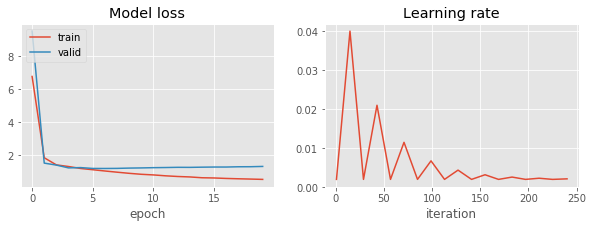

In [60]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'valid'], loc='upper left')

ax2.plot(clr_tri.history['iterations'], clr_tri.history['lr'])
ax2.set_title('Learning rate')
ax2.set_xlabel('iteration')

In [61]:
Counter(X_train['AdoptionSpeed'])

Counter({2.0: 4037, 0.0: 410, 3.0: 3259, 1.0: 3090, 4.0: 4197})

In [62]:
# Coeffs gotten from here: https://www.kaggle.com/skooch/petfinder-simple-lgbm-baseline
coeffs[0] = 1.69
coeffs[1] = 2.2
coeffs[3] = 2.9
#test_predictions = optR.predict(oof_test.mean(axis=1), coeffs)
print('True Counter',Counter(X_train['AdoptionSpeed']))
train_pred_keras = eval_predict(y_pred=oof_train_keras, coeffs=list(coeffs)).astype(int)
print('Train pred Counter',Counter(train_pred_keras))
test_pred_keras = eval_predict(y_pred=adoptions_keras/nfolds, coeffs=list(coeffs)).astype(int)
print('Test pred Counter',Counter(test_pred_keras))

True Counter Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Train pred Counter Counter({4: 7636, 1: 4728, 0: 2629})
Test pred Counter Counter({2: 1252, 4: 1074, 1: 837, 3: 663, 0: 122})


In [63]:
#train_stack = np.concatenate(( train_pred_keras, train_predictions_lgb), axis=1)
#test_stack = np.concatenate(( test_pred_keras, train_predictions_lgb), axis=1)
train_stack = np.vstack([train_pred_keras, train_predictions_lgb]).transpose()
test_stack = np.vstack([test_pred_keras, test_predictions_lgb]).transpose()

In [64]:
from sklearn.linear_model import Ridge

In [65]:
#train_stack = np.vstack([oof_lgb_3, oof_xgb_3]).transpose()
#test_stack = np.vstack([predictions_lgb_3, predictions_xgb_3]).transpose()

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
oof = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])
qwk_scores = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, X_train['AdoptionSpeed'].values)):
    #print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], X_train['AdoptionSpeed'].iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], X_train['AdoptionSpeed'].iloc[val_idx].values

    clf = Ridge(alpha=1)
    clf.fit(trn_data, trn_y)
    val_pred = clf.predict(val_data)
    #print(val_pred)
    #print(y_val)
    #optR = OptimizedRounder()
    #optR.fit(val_pred, y_val)
    #coefficients = optR.coefficients()
    #coefficients[0] = 1.645
    #coefficients[1] = 2.115
    #coefficients[3] = 2.84
    pred_val_y_k = eval_predict(y_pred=val_pred, coeffs=list(coeffs)).astype(int)

    #pred_val_y_k = optR.predict(val_pred, coefficients)
    print("Valid Counts = ", Counter(val_y))
    print("Predicted Counts = ", Counter(pred_val_y_k))
    #print("Coefficients = ", coefficients)
    qwk = quadratic_weighted_kappa(val_y, pred_val_y_k)
    qwk_scores.append(qwk)
    print("QWK = ", qwk)
    
    oof[val_idx] = clf.predict(val_data)
    predictions += clf.predict(test_stack) / folds.n_splits
print('{} cv mean QWK score : {}'.format('Stacked_model_ridge', np.mean(qwk_scores)))

Valid Counts =  Counter({4.0: 420, 2.0: 404, 3.0: 326, 1.0: 309, 0.0: 41})
Predicted Counts =  Counter({4: 548, 1: 418, 2: 415, 0: 116, 3: 3})
QWK =  0.4371600081172551
Valid Counts =  Counter({4.0: 420, 2.0: 404, 3.0: 326, 1.0: 309, 0.0: 41})
Predicted Counts =  Counter({4: 590, 1: 402, 2: 284, 3: 113, 0: 111})
QWK =  0.42076096109033234
Valid Counts =  Counter({4.0: 420, 2.0: 404, 3.0: 326, 1.0: 309, 0.0: 41})
Predicted Counts =  Counter({4: 608, 1: 355, 2: 329, 3: 106, 0: 102})
QWK =  0.4013903450486487
Valid Counts =  Counter({4.0: 420, 2.0: 404, 3.0: 326, 1.0: 309, 0.0: 41})
Predicted Counts =  Counter({4: 626, 1: 379, 2: 267, 3: 143, 0: 85})
QWK =  0.42725517019393244
Valid Counts =  Counter({4.0: 420, 2.0: 404, 3.0: 326, 1.0: 309, 0.0: 41})
Predicted Counts =  Counter({4: 603, 1: 373, 2: 339, 0: 112, 3: 73})
QWK =  0.46046139310272416
Valid Counts =  Counter({4.0: 420, 2.0: 404, 3.0: 326, 1.0: 309, 0.0: 41})
Predicted Counts =  Counter({4: 601, 1: 375, 2: 333, 0: 123, 3: 68})
QW

In [66]:
predictions

array([2.10045586, 2.85503377, 2.96306836, ..., 1.56111503, 1.99242128,
       3.28634001])

In [67]:
pred_final = eval_predict(y_pred=predictions, coeffs=list(coeffs)).astype(int)

In [68]:
pred_final

array([1, 3, 4, ..., 0, 1, 4])

In [69]:
Counter(pred_final)

Counter({1: 1262, 3: 635, 4: 1190, 2: 638, 0: 223})

In [70]:
Counter(test_pred_keras)

Counter({2: 1252, 3: 663, 4: 1074, 1: 837, 0: 122})

In [71]:
Counter(test_predictions_lgb)

Counter({1.0: 1409, 3.0: 1091, 4.0: 829, 2.0: 320, 0.0: 299})

In [72]:
# Generate submission:

submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': pred_final.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)

In [73]:
submission.head()

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,3
2,72000c4c5,4
3,e147a4b9f,3
4,43fbba852,4
